In [17]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import glob
import pickle
import re

from skimage.io import imread
from sklearn.metrics.pairwise import cosine_similarity
import scipy as sc

import io
import sys

import concurrent.futures

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
with open('/content/drive/MyDrive/ADM/Cdiscount/final_data','rb') as f:
  final_data = pickle.load(f)

In [6]:
final_data = final_data[final_data["product_id"].duplicated()]
final_data.index.rename('picture_id',inplace=True)
final_data.reset_index(inplace=True)
final_data

,picture_id,category_id,product_id,picture
0,2,1000001703,2572285,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
1,5,1000001703,2695158,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
2,11,1000001703,2899743,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
3,13,1000001703,2868296,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
4,14,1000001703,2868296,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
...,...,...,...,...
14549,33248,1000021535,2720744,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
14550,33249,1000021535,2720744,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
14551,33251,1000021535,2594064,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...
14552,33252,1000021535,2594064,{'picture': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00...


In [ ]:
with open('/content/drive/MyDrive/ADM/Cdiscount/final_data_1','ab') as f:
  pickle.dump(final_data,f)

In [ ]:
images = {}
for index,image_path in tqdm(final_data.iterrows()):
    image = imread(io.BytesIO(image_path.picture['picture']))
    images[image_path.picture_id] = image  

In [ ]:
with open('/content/drive/MyDrive/ADM/Cdiscount/fourteen_images_dict_pickle','ab') as f:
  pickle.dump(final_images,f)

In [ ]:
def load_image(image):
  #image = plt.imread(image)
  img = tf.image.convert_image_dtype(image, tf.float32)
  img = tf.image.resize(img, [400, 400])
  img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
  return img

# content layers describe the image subject
content_layers = ['block5_conv2'] 

# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
  outputs = [baseline_model.get_layer(name).output for name in layer_names]
  model = Model([vgg.input], outputs)
  return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleModel, self).__init__()
    self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # scale back the pixel values
    inputs = inputs*255.0
    # preprocess them with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs)
    # pass through the reduced network
    outputs = self.vgg(preprocessed_input)
    # segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # calculate the gram matrix for each layer
    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    # assign the content representation and gram matrix in
    # a layer by layer fashion in dicts
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 
    
# compute styles
image_style_embeddings = {}
#pic_array = []
#image_array = []

for index,image_path in tqdm(final_data.iterrows(),desc='data_iter'):
    image_tensor = load_image(imread(io.BytesIO(image_path.picture['picture'])))
    style = style_to_vec( image_to_style(image_tensor) )
    #dim_size_array = np.array(style,dtype='float16')

    #pic_array.append(image_path.picture_id)
    #image_array.append(dim_size_array)
    #insert(connection,image_path.picture_id,dim_size_array)
    #image_style_embeddings[image_path.picture_id] = style
    np.savez('/content/drive/MyDrive/ADM/Cdiscount/Embeddings/'+str(image_path.picture_id)+'.npz',style)

In [7]:
file_paths_temp = glob.glob('/content/drive/MyDrive/ADM/Cdiscount/Embeddings/*npz')
file_paths_temp[:10]

['/content/drive/MyDrive/ADM/Cdiscount/Embeddings/31662.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/31667.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/31668.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/31669.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/31671.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/31672.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/31673.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/31675.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/31676.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/31677.npz']

In [8]:
def sort_glob(file):
  file_path_dic ={}
  for f in file:
    file_path_dic[int(re.findall('[0-9]+',f)[0])] = f

  file_paths = []
  sorted_file_path = sorted(file_path_dic.items())

  for tup in sorted_file_path:
    file_paths.append(tup[1])
  
  return file_paths

In [9]:
file_paths = sort_glob(file_paths_temp)
file_paths[:10]

['/content/drive/MyDrive/ADM/Cdiscount/Embeddings/2.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/5.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/11.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/13.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/14.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/17.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/21.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/22.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/23.npz',
 '/content/drive/MyDrive/ADM/Cdiscount/Embeddings/27.npz']

In [32]:
with open('/content/drive/MyDrive/ADM/Cdiscount/fourteen_images_dict_pickle','rb') as f:
  images = pickle.load(f)

In [ ]:
images[2]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [25]:
image_embeddings ={}
i = 0
def edit(file):

  npz_file = np.load(file)
  picture_id = int(re.findall('[0-9]+',file)[0])
  image_vector = npz_file['arr_0']
  image_embeddings[picture_id] = image_vector

In [ ]:
with concurrent.futures.ThreadPoolExecutor(max_workers=30) as executor:
        list(tqdm(executor.map(edit,file_paths), total = len(file_paths)))

array([   950.4479 ,    303.02634,    597.8266 , ...,  26117.713  ,
        36980.76   , 112168.55   ], dtype=float32)

In [ ]:
del(images)

In [29]:
with open('/content/drive/MyDrive/ADM/Cdiscount/image_style_embeddings','ab') as f:
  pickle.dump(image_embeddings,f)

[(99, 0.0), (13153, 0.03253835439682007), (13234, 0.033457934856414795), (12590, 0.03529912233352661), (13152, 0.03631561994552612), (3570, 0.03839915990829468), (22753, 0.040182650089263916), (13232, 0.04027402400970459), (13284, 0.0409887433052063), (12653, 0.04186218976974487), (22754, 0.04222297668457031), (13238, 0.0434727668762207), (4431, 0.04366964101791382), (11214, 0.044786155223846436), (13283, 0.04489123821258545), (22862, 0.04501986503601074), (13282, 0.046006739139556885), (7799, 0.04754096269607544), (7758, 0.047589123249053955), (31946, 0.04779243469238281), (31982, 0.04779243469238281), (32040, 0.04779243469238281), (32006, 0.04779243469238281), (32155, 0.04779243469238281), (12695, 0.04779541492462158), (7597, 0.04802680015563965), (7664, 0.04802680015563965), (7791, 0.04802680015563965), (7922, 0.04859519004821777), (344, 0.048709869384765625), (4433, 0.05229586362838745), (12807, 0.05293142795562744), (1975, 0.0535009503364563), (2057, 0.05368983745574951), (14486, 

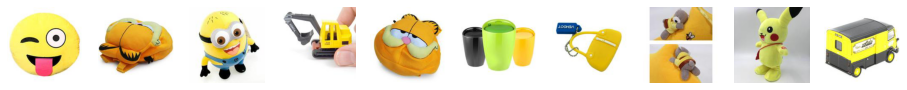

In [34]:
def search_by_style(reference_image, max_results=10):
    v0 = image_embeddings[reference_image]
    distances = {}
    for k,v in image_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d
    #print(distances)
    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    print(sorted_neighbors)

    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()
    
    plt.show()

# images mostly match the reference style, although not perfectly
search_by_style(99)
#search_by_style('s_cubism-02.jpg')